In [2]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from wordcloud import WordCloud

In [3]:
path = "/content/drive/MyDrive/Colab Notebooks/malicious_phish.csv"
df = pd.read_csv(path)
print(df)

                                                      url        type
0                                        br-icloud.com.br    phishing
1                     mp3raid.com/music/krizz_kaliko.html      benign
2                         bopsecrets.org/rexroth/cr/1.htm      benign
3       http://www.garage-pirenne.be/index.php?option=...  defacement
4       http://adventure-nicaragua.net/index.php?optio...  defacement
...                                                   ...         ...
651186            xbox360.ign.com/objects/850/850402.html    phishing
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/    phishing
651188         www.gamespot.com/xbox360/action/deadspace/    phishing
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)    phishing
651190          www.angelfire.com/goth/devilmaycrytonite/    phishing

[651191 rows x 2 columns]


In [4]:
df.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [5]:
df.isnull().values.any()

False

In [6]:
df_phish = df[df.type=='phishing']
df_malware = df[df.type=='malware']
df_deface = df[df.type=='defacement']
df_benign = df[df.type=='benign']

In [7]:
###Feature Engineering

In [8]:
import re
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [9]:
from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [10]:
#!pip install googlesearch-python
!pip install googlesearch-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 8.8 MB/s 
     |████████████████████████████████| 115 kB 58.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [11]:
from googlesearch import search

def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))

In [12]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


In [13]:
def count_www(url):
    url.count('www')
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))

def count_atrate(url):
     
    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))


def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    
    
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [14]:
def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))

In [15]:
def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

def url_length(url):
    return len(str(url))


#Length of URL
df['url_length'] = df['url'].apply(lambda i: url_length(i))
#Hostname Length

def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

df.head()

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters


df['count-letters']= df['url'].apply(lambda i: letter_count(i))

df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count?,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,0,0,0,1,0,16,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,0,0,0,35,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,0,0,0,31,0,0,1,25
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,0,1,1,4,88,21,0,7,63
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,0,1,1,3,235,23,0,22,199


In [16]:
#!pip install tld
!pip install tld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412 kB 20.7 MB/s 


In [17]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [18]:
df = df.drop("tld",1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [19]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

In [20]:
df['type'].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [21]:
#### Target Encoding 

from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

0    428103
1     96457
3     94111
2     32520
Name: type_code, dtype: int64

In [22]:
### Creation of Feature & Target

In [23]:
#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']

In [24]:
X.head()

,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,2,0,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,0,0,2,0,0,2,0,0,0,0,...,0,0,0,35,0,0,5,-1,1,29
2,0,0,2,0,0,3,0,0,0,0,...,0,0,0,31,0,0,7,-1,1,25
3,0,1,3,1,0,1,0,0,0,1,...,1,1,4,88,21,0,9,2,7,63
4,0,1,2,0,0,1,0,0,0,1,...,1,1,3,235,23,0,9,3,22,199


In [25]:
X.columns

Index(['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters'],
      dtype='object')

In [26]:
####   Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

In [27]:
#### Model Building  


In [28]:
#### 1. Random Forest Classifier  (learn the pattern ... ** rf.predict(X_test) **)

In [29]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
rf = RandomForestClassifier(n_estimators=100,max_features='sqrt')
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.98      0.98     85621
  defacement       0.98      0.99      0.99     19292
    phishing       0.99      0.94      0.97      6504
     malware       0.91      0.86      0.88     18822

    accuracy                           0.97    130239
   macro avg       0.96      0.95      0.95    130239
weighted avg       0.97      0.97      0.97    130239

accuracy:   0.966


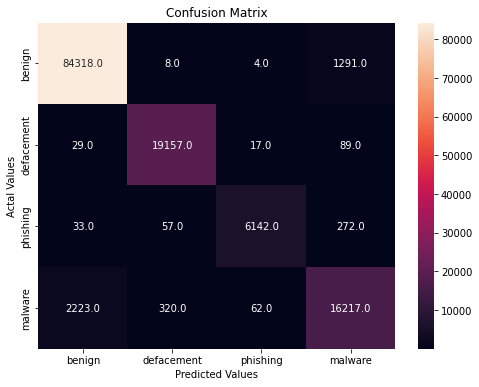

In [30]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

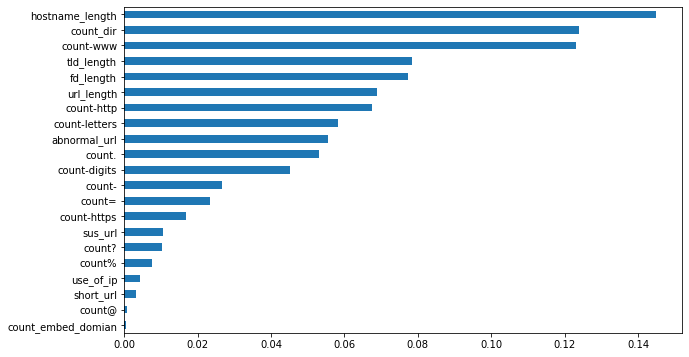

In [31]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

In [38]:
#### Deep Neural Network

DNN = Sequential()
DNN.add(Dense(2, input_dim=21, activation='relu'))
# model.add(Dropout(.2))
DNN.add(Dense(2, activation='relu'))
# model.add(Dropout(.2))
DNN.add(Dense(1, activation='sigmoid'))
   
DNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
DNN.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
_, accuracy = DNN.evaluate(X_test, y_test)
   
print(accuracy*100)

4070/4070 [==============================] - 5s 1ms/step - loss: -4741572.0000 - accuracy: 0.5676
56.757962703704834


In [41]:
!pip install tensorflow scikeras scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [53]:
### Deep Neural Network for Ensambling
# https://stackoverflow.com/questions/60350049/tensorflow-fit-gives-typeerror-cannot-clone-object-error
# https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/

def getModel():
    Dnn = Sequential()
    Dnn.add(Dense(2, input_dim=21, activation='relu'))
    Dnn.add(Dense(1, activation='sigmoid'))
    Dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return Dnn

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
epochs = [1, 5]

param_grid = dict(epochs=epochs, optimizer=optimizer)
Kmodel = KerasClassifier(model=getModel, epochs=5, batch_size=10, verbose=0)

In [55]:
print(Kmodel.get_params().keys())

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'class_weight'])


In [58]:
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
epochs = [5]
batches = [5]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches)
grid = GridSearchCV(estimator=Kmodel, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)

In [60]:
print(grid)

GridSearchCV(estimator=KerasClassifier(batch_size=10, epochs=5, model=<function getModel at 0x7f49c0635710>, verbose=0),
             param_grid={'batch_size': [5], 'epochs': [5],
                         'optimizer': ['rmsprop', 'adam']})


In [33]:
!pip install mlrose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=28611225d26a82cec15319c0ff7941c9c486296a5dabf3586cc589b91c0136b0
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built sklearn


In [34]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

In [35]:
from mlxtend.classifier import EnsembleVoteClassifier

In [60]:
from sklearn.ensemble import StackingClassifier

In [ ]:
clfs = [rf, grid]

model_cls = EnsembleVoteClassifier(
    clfs = clfs,
    voting = 'soft',
    weights = [1,1],
).fit(X_train, y_train)

pred_cls = model_cls.predict(X_test)

print("Accuracy", round(accuracy_score(y_test, pred_cls), 2))

In [53]:
### Get pickle model ==> After train we get the model and save it for letter on use it
import pickle

with open('model_pickleRF', 'wb') as f:
  pickle.dump(rf, f)

In [52]:
with open('model_pickle', 'rb') as f:
  MODEL = pickle.load(f)

In [ ]:
# MODEL.predict(url)